# Hough Transform

1948


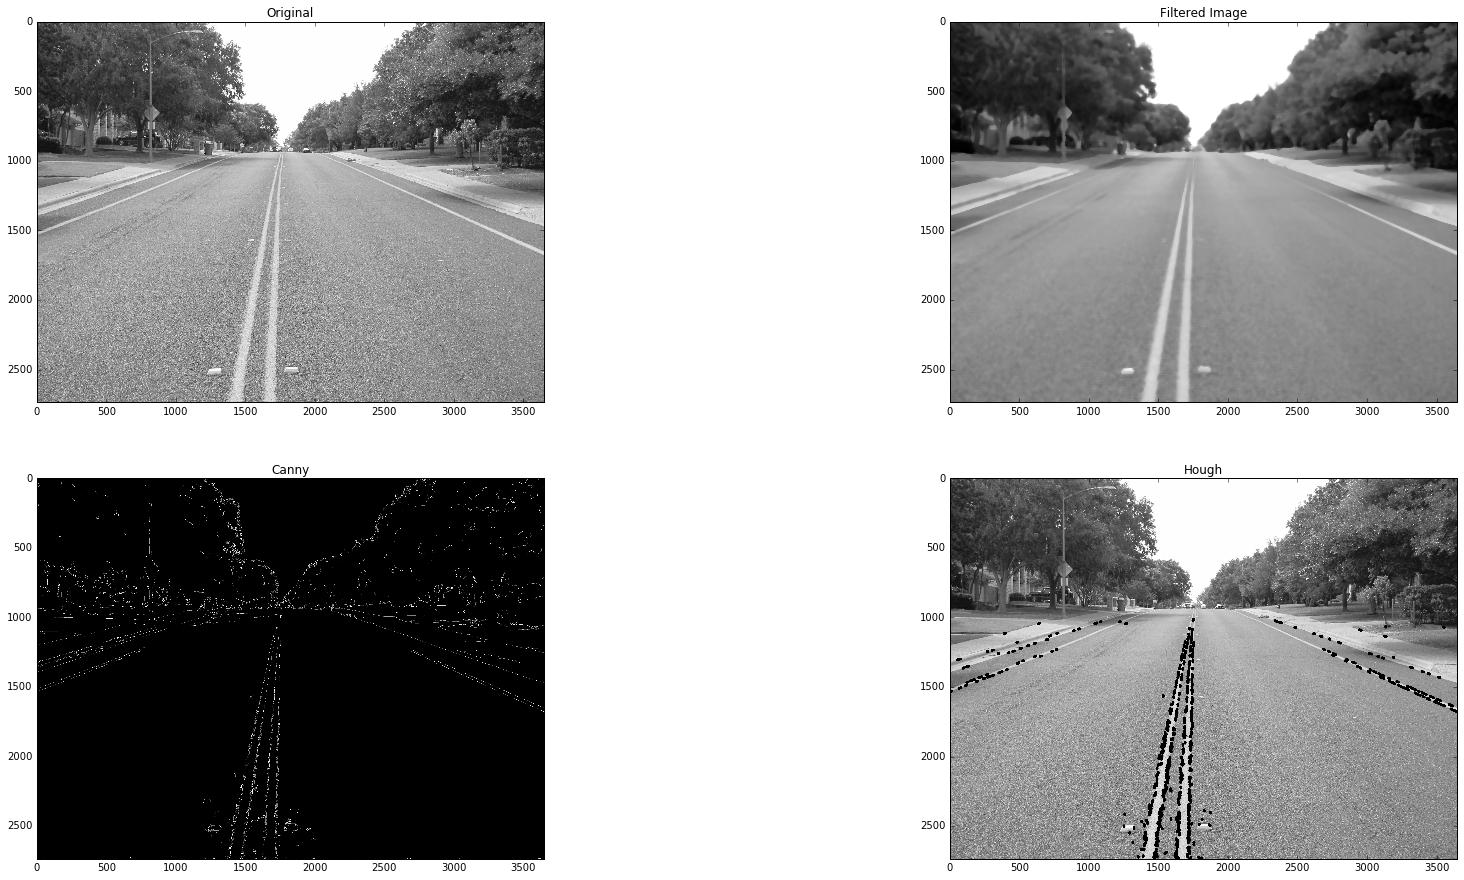

In [45]:
# Implementing a median filter to a salt & pepper noise
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline 

# Create a figure
fig = plt.figure(figsize=(30,15))

# Get the image
img = cv2.imread("lane.jpg",0)
a=fig.add_subplot(2,2,1)
imgplot = plt.imshow(img, cmap='Greys_r')
a.set_title('Original')

# Apply a median filter and try to clean the noise
filteredImg = cv2.medianBlur(img,31)
a=fig.add_subplot(2,2,2)
imgplot = plt.imshow(np.array(filteredImg), cmap='Greys_r')
a.set_title('Filtered Image')

# Apply a canny edge detector
canny = cv2.Canny(filteredImg,0,25,apertureSize = 3)
a=fig.add_subplot(2,2,3)
imgplot = plt.imshow(np.array(canny), cmap='Greys_r')
a.set_title('Canny')

# Apply a hough line detector
LaneMarkings = np.copy(img)
lines = cv2.HoughLinesP(canny,1,np.pi/180,10,2000,5)
print lines.shape[0]
for line in lines:
    for x1,y1,x2,y2 in line:
        if (y1 > 1000 and y2 > 1000) and (abs(y2 - y1) > 2):
            cv2.line(LaneMarkings,(x1,y1),(x2,y2),0,20)

a=fig.add_subplot(2,2,4)
imgplot = plt.imshow(np.array(LaneMarkings), cmap='Greys_r')
a.set_title('Hough')

plt.show()
    